# Import package

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
import pickle

import re

# Import Data

In [4]:
data = pd.read_csv('train_preprocess.csv', sep='\t',header = None)
df = data.rename(columns={0: 'text', 1: 'label'})
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


# CLEANSING DATA

In [6]:
category = pd.get_dummies(df.label)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='label')

df_baru['text'] = df_baru['text'].replace('\n', ' ').str.lower()

def fun(x):
    y = re.sub(r'[^a-zA-Z0-9. ]', '', x)
    return y

df_baru['text_new'] = df_baru['text'].apply(lambda x : fun(x))

df_baru['text_new'] = df_baru['text_new'].replace('   ', ' ')
df_baru['text_new'] = df_baru['text_new'].replace('  ', ' ')



df_baru.head()

,text,negative,neutral,positive,text_new
0,warung ini dimiliki oleh pengusaha pabrik tahu...,0,0,1,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,0,1,0,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,0,0,1,lokasi strategis di jalan sumatera bandung . t...
3,betapa bahagia nya diri ini saat unboxing pake...,0,0,1,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,1,0,0,duh . jadi mahasiswa jangan sombong dong . kas...


# PENAMAAN VARIABEL X, Y DAN PEMBUATAN TOKENIZER

In [7]:
x = df_baru['text_new'].values
y = df_baru[['negative', 'neutral', 'positive']].values

In [8]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(x)
sekuens_x = tokenizer.texts_to_sequences(x)
padded_x = pad_sequences(sekuens_x)

In [9]:
pickle.dump(tokenizer, open("feature_New_lstm.sav", "wb"))

# SPLIT TRAIN , VALIDATION AND TEST 

In [10]:
x_train, x_test, y_train, y_test = train_test_split(padded_x, y, test_size=0.2, random_state = 4)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 4)

# MODEL LSTM

In [11]:
%%time

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=100000, output_dim=128),
    tf.keras.layers.LSTM(32, dropout=0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_categorical_accuracy') > 0.90 ):
            self.model.stop_training = True

callbacks = myCallback()

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_accuracy'])

num_epochs = 4
fit = model.fit(x_train, 
                y_train, 
                batch_size = 16,
                epochs=num_epochs, 
                validation_data=(x_val, y_val),     
                callbacks = [callbacks]
)

Epoch 1/4
440/440 [==============================] - 164s 365ms/step - loss: 0.5852 - categorical_accuracy: 0.7710 - val_loss: 0.3517 - val_categorical_accuracy: 0.8784
Epoch 2/4
440/440 [==============================] - 136s 308ms/step - loss: 0.2819 - categorical_accuracy: 0.8996 - val_loss: 0.3118 - val_categorical_accuracy: 0.8903
Epoch 3/4
440/440 [==============================] - 151s 342ms/step - loss: 0.1915 - categorical_accuracy: 0.9314 - val_loss: 0.3308 - val_categorical_accuracy: 0.8744
Epoch 4/4
440/440 [==============================] - 207s 471ms/step - loss: 0.1251 - categorical_accuracy: 0.9572 - val_loss: 0.3503 - val_categorical_accuracy: 0.8864
Wall time: 10min 58s


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         12800000  
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 12,820,899
Trainable params: 12,820,899
Non-trainable params: 0
_________________________________________________________________


In [13]:
pickle.dump(model, open("model_lstm.sav", 'wb'))

Text(0.5, 1.0, 'Accuracy')

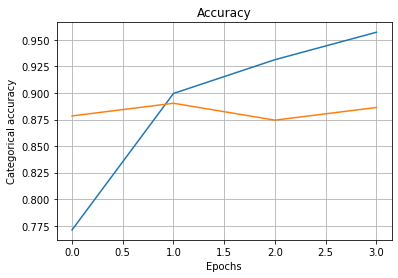

In [17]:
plt.plot(fit.history['categorical_accuracy'])
plt.plot(fit.history['val_categorical_accuracy'])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.title('Accuracy')

# AKURASI

In [18]:
train_loss, train_acc = model.evaluate(x_train, y_train)
val_loss, val_acc = model.evaluate(x_val, y_val)
test_loss, test_acc = model.evaluate(x_test, y_test)

print('\nTrain: %.3f, val: %.3f, test: %.3f,' % (train_acc, val_acc, test_acc))

69/69 [==============================] - 1s 13ms/step - loss: 0.4142 - categorical_accuracy: 0.8659

Train: 0.974, val: 0.886, test: 0.866,
